<a href="https://colab.research.google.com/github/MacherelR/AutonomousRcCar/blob/main/CNN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lier l'espace Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
model_output_dir = '/content/gdrive/My Drive/Colab Notebooks/LaneNavigation'


Mounted at /content/gdrive


In [2]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Colab Notebooks')

**Importation des différentes librairies**

In [3]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image



import csv

import ML_Lib

tf.__version__: 2.5.0
keras.__version__: 2.5.0


**Chargement des données du dossier Github**


Cloning into 'AutonomousRcCar'...
remote: Enumerating objects: 7383, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 7383 (delta 4), reused 269 (delta 3), pack-reused 7111
Receiving objects: 100% (7383/7383), 775.61 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (285/285), done.
Checking out files: 100% (7973/7973), done.
AutonomousRcCar  gdrive  sample_data
Index : 2094
image_path: /content/AutonomousRcCar/Datas/DataCollection/SET3/Image_4936.png
steering_Angle: 124


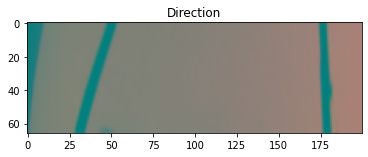

In [4]:
!cd /content
if not os.path.isdir("AutonomousRcCar"):
  !git clone https://github.com/MacherelR/AutonomousRcCar
!ls

dataDirectory = '/content/AutonomousRcCar/Datas/DataCollection' # DataCollection
steeringList,img_path,namesList = ML_Lib.readFiles(dataDirectory)
df = pd.DataFrame()
df['ImagePath'] = img_path
df['Angle'] = steeringList


test = True
idx = random.randrange(len(steeringList))
print(F"Index : {idx}")
if test :
  img = ML_Lib.imreadModif(img_path[idx])
  preprocessed = ML_Lib.ImagePreprocess(img)
  steering = steeringList[idx]
  plt.imshow(preprocessed)
  plt.title('Direction')
  print("image_path: %s" % img_path[idx] )
  print("steering_Angle: %d" % steeringList[idx] )

ERROR:root:No traceback has been produced, nothing to debug.


**Affichage de la taille du DataSet**

3292
3292
3292


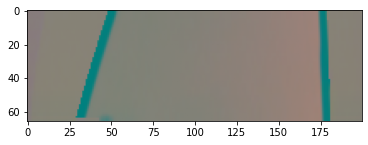

In [5]:
print(len(steeringList))
print(len(img_path))
print(len(namesList))
if test:
  EndProcessed = ML_Lib.secondProcess(preprocessed)
  plt.imshow(EndProcessed)

**Affichage de la disposition du DataSet**

(array([17.0000, 8.0000, 9.0000, 33.0000, 24.0000, 68.0000, 76.0000,
        58.0000, 75.0000, 54.0000, 97.0000, 204.0000, 619.0000, 448.0000,
        56.0000, 161.0000, 103.0000, 133.0000, 137.0000, 180.0000,
        251.0000, 304.0000, 67.0000, 72.0000, 38.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <a list of 25 Patch objects>)

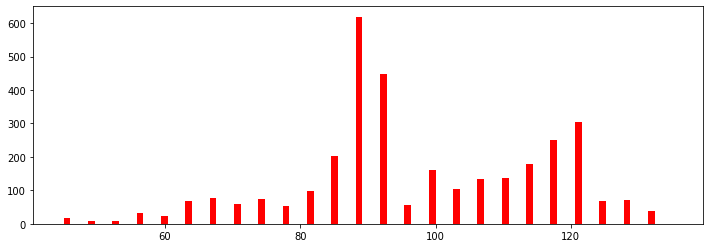

In [6]:
nBins = 25
samplesPerBin = 400
hist , bins = np.histogram(df['Angle'],nBins)
fig,axes = plt.subplots(1,1,figsize=(12,4))
axes.hist(df['Angle'],bins= nBins,width = 1,color='red')

**Séparation du DataSet**

Training data: 2304
Validation data: 988


Text(0.5, 1.0, 'Validation Data')

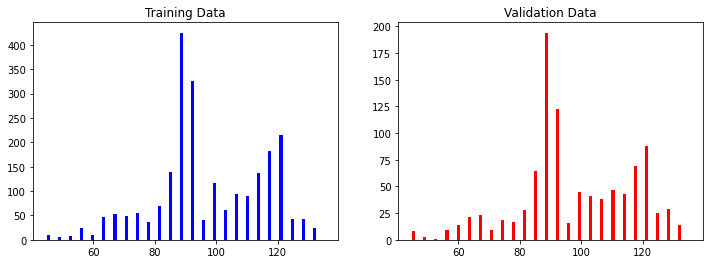

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(img_path,steeringList, test_size= 0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_validation)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=nBins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_validation, bins=nBins, width=1, color='red')
axes[1].set_title('Validation Data')

**Test des modifications d'images**

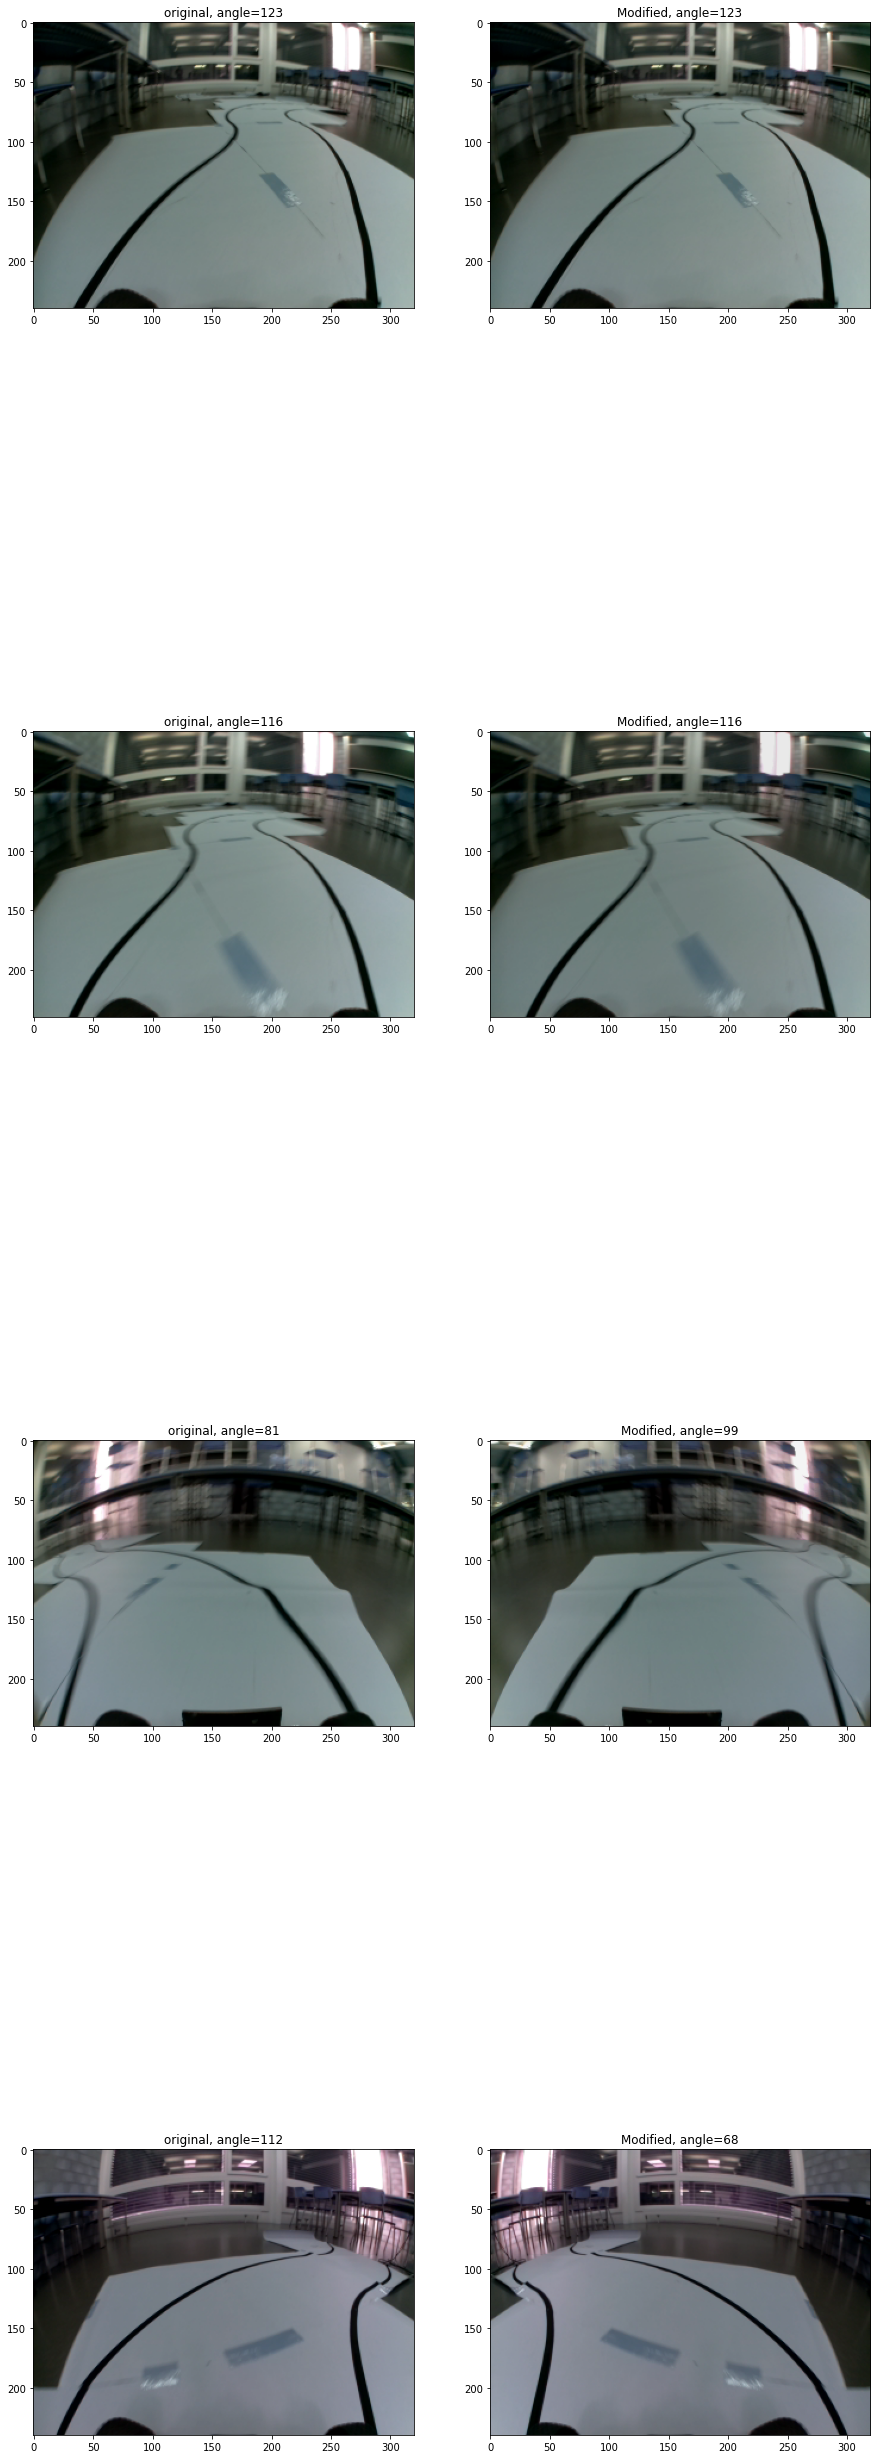

In [8]:
ncol = 2
nrow = 4
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(img_path) - 1)
    image_path = img_path[rand_index]
    steering_angle_orig = steeringList[rand_index]
      
    image_orig = ML_Lib.imreadModif(image_path)
    image_aug, steering_angle_aug = ML_Lib.randomModify(image_orig, steering_angle_orig)
      
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("Modified, angle=%s" % steering_angle_aug)

**Test du processing**

Text(0.5, 1.0, 'processed')

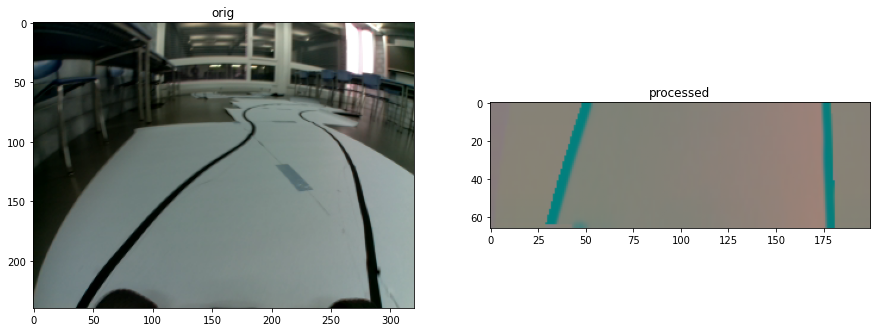

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = ML_Lib.imreadModif(img_path[idx])
image_processed = ML_Lib.secondProcess(ML_Lib.ImagePreprocess(image_orig))
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

**Définition du modèle**

In [10]:

def nvidia_model():
    model = Sequential(name='Nvidia_Model')  
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(learning_rate=0.5*1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

**Création du modèle et affichage de ses propriétés**

In [11]:
model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

**Tests du générateur dynamique de données**

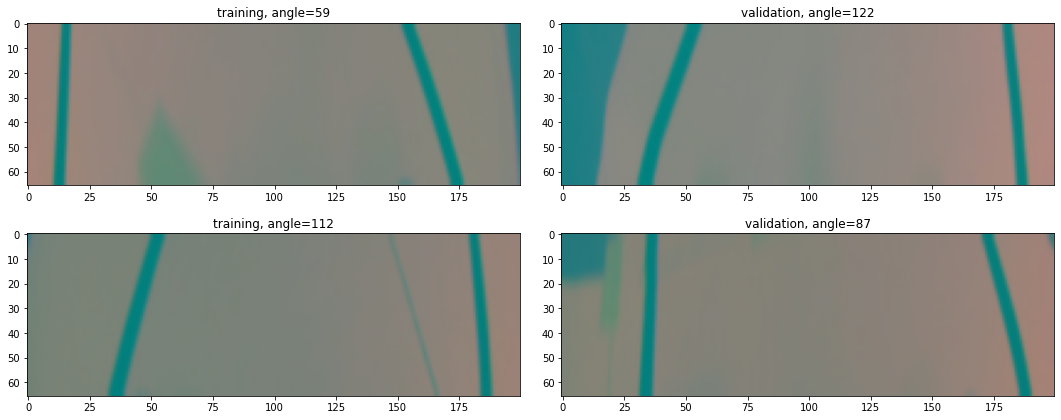

In [12]:
ncols = 2
nrows = 2

xTrainBatch,yTrainBatch = next(ML_Lib.dataGenerator(X_train,y_train,nrows,True))
xValidationBatch,yValidationBatch = next(ML_Lib.dataGenerator(X_validation,y_validation,nrows,False))

fig,axes = plt.subplots(nrows,ncols,figsize = (15,6))
fig.tight_layout()

for i in range(nrows):
  axes[i][0].imshow(xTrainBatch[i])
  axes[i][0].set_title("training, angle=%s" % yTrainBatch[i])
  axes[i][1].imshow(xValidationBatch[i])
  axes[i][1].set_title("validation, angle=%s" % yValidationBatch[i])

In [13]:
# Start TensorBoard
logDirRoot = f'{model_output_dir}/logs'

In [ ]:
# If not using generator ! 
Xtrain = list(map(ML_Lib.ImagePreprocess,map(ML_Lib.imreadModif,X_train)))

Ytrain = y_train
Xval = list(map(ML_Lib.ImagePreprocess,map(ML_Lib.imreadModif,X_validation)))
Yval = y_validation

**Entraînement du CNN**

In [ ]:
if True :
  checkpointCallback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'laneNavigationChecklrDown.h5'),verbose=1,save_best_only=True)
  history = model.fit(ML_Lib.dataGenerator( X_train, y_train, batchSize=400, isTraining=True),
                      steps_per_epoch=300,
                      epochs=15,
                      validation_data = ML_Lib.dataGenerator( X_validation, y_validation, batchSize=200, isTraining=False), #,(Xval,Yval)
                      validation_steps=150,
                      verbose=1,
                      shuffle=1,
                      callbacks=[checkpointCallback])
  # always save model output as soon as model finishes training
  model.save(os.path.join(model_output_dir,'lane_navigation_TestlrDown.h5'))

  date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
  history_path = os.path.join(model_output_dir,'historylrDown.pickle')
  with open(history_path, 'wb') as f:
      pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/15
300/300 [==============================] - 1376s 5s/step - loss: 1406.2914 - val_loss: 459.8427

Epoch 00001: val_loss improved from inf to 459.84268, saving model to /content/gdrive/My Drive/Colab Notebooks/LaneNavigation/laneNavigationChecklrDown.h5
Epoch 2/15
300/300 [==============================] - 1349s 4s/step - loss: 339.7751 - val_loss: 208.8109

Epoch 00002: val_loss improved from 459.84268 to 208.81088, saving model to /content/gdrive/My Drive/Colab Notebooks/LaneNavigation/laneNavigationChecklrDown.h5
Epoch 3/15
300/300 [==============================] - 1348s 4s/step - loss: 174.8776 - val_loss: 137.2623

Epoch 00003: val_loss improved from 208.81088 to 137.26225, saving model to /content/gdrive/My Drive/Colab Notebooks/LaneNavigation/laneNavigationChecklrDown.h5
Epoch 4/15
300/300 [==============================] - 1354s 5s/step - loss: 117.2890 - val_loss: 122.5722

Epoch 00004: val_loss improved from 137.26225 to 122.57220, saving model to /content/gdrive/My

In [ ]:
#%debug


**Affichage des données d'entraînement**

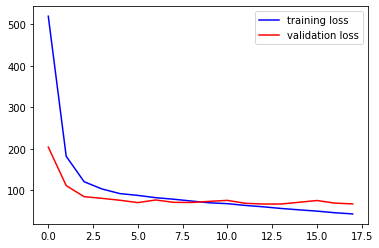

In [ ]:
# Plot training and validation loss !! 
hist_path = os.path.join(model_output_dir,'historylrDown.pickle')
with open(hist_path,'rb') as fd :
  history = pickle.load(fd)

plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

**Fonctions d'évaluation de performances**

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_TestlrDown.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

**Evaluation des performances du réseau**

mse       = 5.8e+01
r_squared = 80.19%



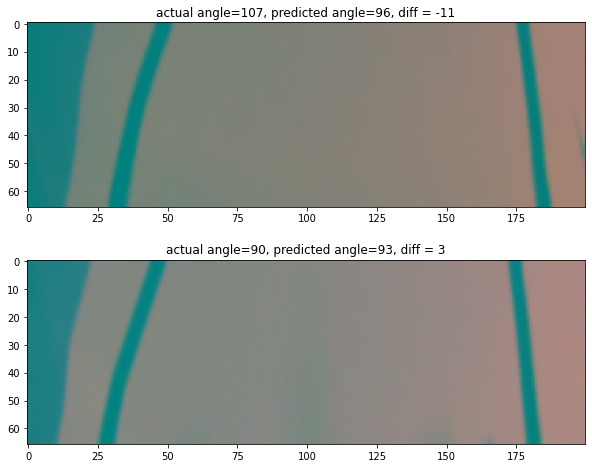

In [ ]:
n_tests = 300
X_test, y_test = next(ML_Lib.dataGenerator(X_validation, y_validation, n_tests, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")

**Conversion du modèle**

In [ ]:
newDir = '/content/gdrive/My Drive/Colab Notebooks/Models/'
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the model.
with open(f'{newDir}/modelConvertedQT3.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwjcqahe2/assets


In [ ]:
print("Float model in Mb:", os.path.getsize(f'{newDir}/modelConvertedWQT.tflite') / float(2**20))
print("Quantized model in Mb:", os.path.getsize(f'{newDir}/modelConvertedQT.tflite') / float(2**20))
print("Compression ratio:", os.path.getsize(f'{newDir}/modelConvertedWQT.tflite')/os.path.getsize(f'{newDir}/modelConvertedQT.tflite'))

Float model in Mb: 0.9679412841796875
Quantized model in Mb: 0.254150390625
Compression ratio: 3.808537463976945
